<a href="https://colab.research.google.com/github/nicoRomeroCuruchet/BBB_DMP_MPU/blob/master/MPU6050_DMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
class KalmanFilter:

    """ 
    Naive implementation of Kalman Filter. The state of the system at time k 
    if given by:  

                  x_{k} = F * x_{k-1} + B*u_{k} + w_{k}
                  z_{k} = H*x_{k} + v_{k}

    F = [[1, -dt],
         [0,  1]]

    B = [[dt],
         [0]]
    
    H = [[1,0]]

    w_{k} is process noise which is Gaussian distributed with a zero mean and 
    with covariance Q to the time k. v_{k}, the noise of the measurement have 
    to be Gaussian distributed as well with a zero mean and R as the covariance.

    The optimal (minimum variance unbiased) estimate is the conditional mean and
    is computed in two steps: the forecast step using the model difference 
    equations and the data assimilation step. Hence the Kalman Filter has a 
    predictor-corrector structure.
    """

    def __init__(self):

        """ constructor """

        self.Q_angle = 0.001       # covariance in the angle
        self.Q_bias = 0.05          # covariance in bias of the rate
        self.R_measure = 0.11       # covariance of noisy process  

        self.angle  = 0.0           # best angle estimation
        self.bias = 0.0             # best bias estimation 
        self.rate = 0.0             # best rate estimation
        self.P = np.zeros((2,2))
        self.K = np.zeros((2,1))


    def get_angle(self, new_angle, new_rate, dt):
    
        """ get the real angle and unbiased rate_angle """

        self.rate = new_rate - self.bias
        self.angle += dt * self.rate;

        self.P[0][0] += dt * (dt*self.P[1][1] - self.P[0][1] - self.P[1][0] + self.Q_angle)
        self.P[0][1] -= dt * self.P[1][1]
        self.P[1][0] -= dt * self.P[1][1]
        self.P[1][1] += self.Q_bias * dt

        S = self.P[0][0] +self.R_measure
        self.K[0] = self.P[0][0] / S;
        self.K[1] = self.P[1][0] / S;

        y = new_angle - self.angle;
        self.angle += self.K[0] * y;
        self.bias += self.K[1] * y;

        P00_temp = self.P[0][0];
        P01_temp = self.P[0][1];

        self.P[0][0] -= self.K[0] * P00_temp;
        self.P[0][1] -= self.K[0] * P01_temp;
        self.P[1][0] -= self.K[1] * P00_temp;
        self.P[1][1] -= self.K[1] * P01_temp;

        return {'angle':float(self.angle), 'bias':float(self.bias)}

In [3]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
import math

dt = 6000 * 1e-6  # sample rate 5ms

data = pd.read_csv('data.csv')                       # read data of de the repository
data['ROLL_DMP'] = data['ROLL_DMP'].astype(float)    # ensures that the values ​​are floats
data['ROLL_ACC'] = data['ROLL_ACC'].astype(float)    
data['ROLL_RATE_DMP'] = data['ROLL_RATE_DMP'].astype(float)  
data['ROLL_RATE_GYRO'] = data['ROLL_RATE_GYRO'].astype(float)
data['time'] = list(np.arange(0,data.shape[0] * dt ,dt))   # the sample rate 5ms so [0,  dt, 2dt, 3dt, ....]

# Apply kalman filter to the data
roll = KalmanFilter()  # apply naive kalman filter over roll
f_angle = lambda acc, gyro, dt: roll.get_angle(acc, gyro, dt)['angle']
vect_roll = np.vectorize(f_angle)   # vectorize the method to apply in the frame's column 
data['KALMAN_FILTERED'] = vect_roll(data['ROLL_ACC'], data['ROLL_RATE_GYRO'], dt)

# flush P y K matrix
roll.P = np.zeros((2,2))
roll.K = np.zeros((2,1))

f_bias =  lambda acc, gyro, dt: roll.get_angle(acc, gyro, dt)['bias']
vect_bias = np.vectorize(f_bias)   # vectorize the method to apply in the frame's column 
data['bias'] = vect_roll(data['ROLL_ACC'], data['ROLL_RATE_GYRO'], dt)
data['ROLL_RATE_UNBIASED'] = data['ROLL_RATE_GYRO'] - data['bias']

(0.0, 25.0)

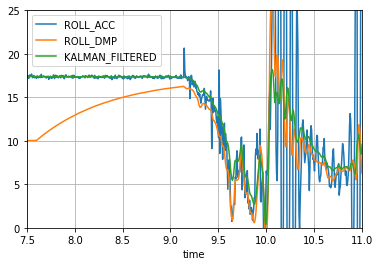

In [4]:
data.plot('time', y=['ROLL_ACC','ROLL_DMP','KALMAN_FILTERED'], grid='True')
plt.xlim(7.5, 11)
plt.ylim(0, 25)

(-50.0, 50.0)

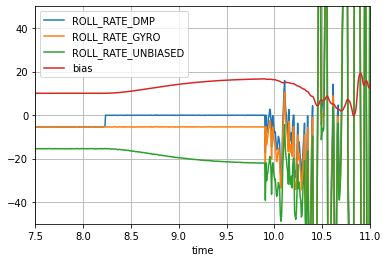

In [ ]:
data.plot('time', y=['ROLL_RATE_DMP', 'ROLL_RATE_GYRO', 'ROLL_RATE_UNBIASED', 'bias'], grid='True')
plt.xlim(7.5, 11)
plt.ylim(-50, 50)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0.0, 25.0)

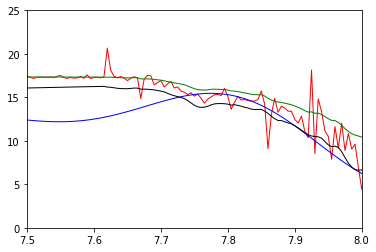

In [ ]:
n = data.shape[0]
f = data['ROLL_ACC']
f_dmp = data['ROLL_DMP']
f_kalman = data['KALMAN_FILTERED']
t = data['time']

fhat = np.fft.fft(f,n)
PSD = fhat * np.conj(fhat) / n              # Power spectrum (power per freq)
freq = (1/(dt*n)) * np.arange(n)            # Create x-axis of frequencies in Hz
L = np.arange(1,np.floor(10),dtype='int')   # Only plot the first half of freqs


indices = PSD > 2800                       # Find all freqs with large power
PSDclean = PSD * indices                    # Zero out all others
fhat = indices * fhat                       # Zero out small Fourier coeffs. in Y
ffilt = np.fft.ifft(fhat)                   # Inverse FFT for filtered time signal

fig,axs = plt.subplots(1,1)
plt.plot(t,f,color='r',LineWidth=1,label='No Filtered')
plt.plot(t,ffilt,color='b',LineWidth=1,label='FFT Filtered')
plt.plot(t,f_kalman,color='g',LineWidth=1,label='DMP')
plt.plot(t,f_dmp,color='k',LineWidth=1,label='Kalman')

plt.xlim(7.5, 8)
plt.ylim(0, 25)